In [84]:
pip install numpy pandas tensorflow torch

Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [86]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [87]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/opt/anaconda3/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /Users/humayrajeba/Documents/Research work/ECG-LSTM/ECG5000.zip
100%|██████████████████████████████████████| 10.6M/10.6M [00:01<00:00, 7.02MB/s]


In [88]:
!unzip -qq ECG5000.zip

replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [89]:
import sys
import numpy as np
import pandas as pd
import torch

# Display Python version
print(f"Python version: {sys.version}")

# Display package versions
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"torch version: {torch.__version__}")


Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
numpy version: 1.26.4
pandas version: 2.2.2
torch version: 2.4.0


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
import torch
import time
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report
import copy
import shutil
import numpy as np
from scipy.io import arff
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F 
from torchvision import datasets, transforms


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
rng = torch.manual_seed(RANDOM_SEED)

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [160]:

from scipy.io import arff
import pandas as pd

# Load the training ARFF file
with open('ECG5000_TRAIN.arff') as f:
    data, meta = arff.loadarff(f)
    train = pd.DataFrame(data)

# Load the test ARFF file
with open('ECG5000_TEST.arff') as f:
    data, meta = arff.loadarff(f)
    test = pd.DataFrame(data)

# Display the first few rows of the training data
print(train.head())
print(test.head())


       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.2

In [166]:

df = pd.concat([train, test])
df = df.sample(frac=1.0)  # Shuffle the DataFrame
df.shape

(5000, 141)

In [169]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
96,-0.353136,-2.759614,-3.962997,-4.440623,-4.533910,-3.658712,-2.350392,-1.857215,-1.385800,-0.566552,...,1.652714,1.726200,1.239197,0.823388,0.333939,0.170350,0.016252,0.950658,0.049003,b'1'
3558,0.312523,-0.991740,-1.856340,-2.570610,-2.959991,-3.038835,-2.848807,-2.680699,-2.356010,-1.826246,...,-1.003047,-1.546277,-2.123628,-2.682337,-3.292281,-3.564623,-2.901497,-2.338263,-0.535226,b'2'
827,-1.688995,-3.931246,-3.971561,-4.189276,-3.214315,-2.212987,-1.851908,-1.426971,-0.629721,-0.468018,...,1.252518,1.221415,0.975212,0.464635,-0.140716,-0.248849,-0.022145,0.847093,-1.141358,b'1'
2294,-0.734067,-3.109719,-3.930306,-3.952606,-3.763617,-2.798732,-1.927060,-1.700598,-1.203373,-0.547849,...,1.533258,1.542586,1.512665,1.291211,0.840025,0.571837,0.592051,1.394501,0.067489,b'1'
1381,-1.506516,-1.593003,-4.102671,-5.363241,-4.892854,-4.000450,-2.716880,-1.408275,-0.602630,0.713466,...,-0.331649,0.269471,0.321987,0.525979,0.804759,0.651227,0.711147,1.058578,-1.874551,b'1'


We have 5,000 examples. Each row represents a single heartbeat record.
We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).



In [170]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [171]:

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [172]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
96,-0.353136,-2.759614,-3.962997,-4.440623,-4.533910,-3.658712,-2.350392,-1.857215,-1.385800,-0.566552,...,1.652714,1.726200,1.239197,0.823388,0.333939,0.170350,0.016252,0.950658,0.049003,b'1'
3558,0.312523,-0.991740,-1.856340,-2.570610,-2.959991,-3.038835,-2.848807,-2.680699,-2.356010,-1.826246,...,-1.003047,-1.546277,-2.123628,-2.682337,-3.292281,-3.564623,-2.901497,-2.338263,-0.535226,b'2'
827,-1.688995,-3.931246,-3.971561,-4.189276,-3.214315,-2.212987,-1.851908,-1.426971,-0.629721,-0.468018,...,1.252518,1.221415,0.975212,0.464635,-0.140716,-0.248849,-0.022145,0.847093,-1.141358,b'1'
2294,-0.734067,-3.109719,-3.930306,-3.952606,-3.763617,-2.798732,-1.927060,-1.700598,-1.203373,-0.547849,...,1.533258,1.542586,1.512665,1.291211,0.840025,0.571837,0.592051,1.394501,0.067489,b'1'
1381,-1.506516,-1.593003,-4.102671,-5.363241,-4.892854,-4.000450,-2.716880,-1.408275,-0.602630,0.713466,...,-0.331649,0.269471,0.321987,0.525979,0.804759,0.651227,0.711147,1.058578,-1.874551,b'1'


In [173]:
df['target'] = df['target'].apply(lambda x: x.decode('utf-8'))


In [174]:
print(df.columns)  # Check if 'target' is the correct column name
print(df.head())   # Display the first few rows to inspect the data


Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)
          att1      att2      att3      att4      att5      att6      att7  \
96   -0.353136 -2.759614 -3.962997 -4.440623 -4.533910 -3.658712 -2.350392   
3558  0.312523 -0.991740 -1.856340 -2.570610 -2.959991 -3.038835 -2.848807   
827  -1.688995 -3.931246 -3.971561 -4.189276 -3.214315 -2.212987 -1.851908   
2294 -0.734067 -3.109719 -3.930306 -3.952606 -3.763617 -2.798732 -1.927060   
1381 -1.506516 -1.593003 -4.102671 -5.363241 -4.892854 -4.000450 -2.716880   

          att8      att9     att10  ...    att132    att133    att134  \
96   -1.857215 -1.385800 -0.566552  ...  1.652714  1.726200  1.239197   
3558 -2.680699 -2.356010 -1.826246  ... -1.003047 -1.546277 -2.123628   
827  -1.426971 -0.629721 -0.468018  ...  1.252518  1.2214

In [175]:
print(df['target'].head())
print(df['target'].dtype)




96      1
3558    2
827     1
2294    1
1381    1
Name: target, dtype: object
object


In [176]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

/var/folders/2r/p_w4swwd3cv52b3h9nn1njtm0000gn/T/ipykernel_1041/2888597445.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names);


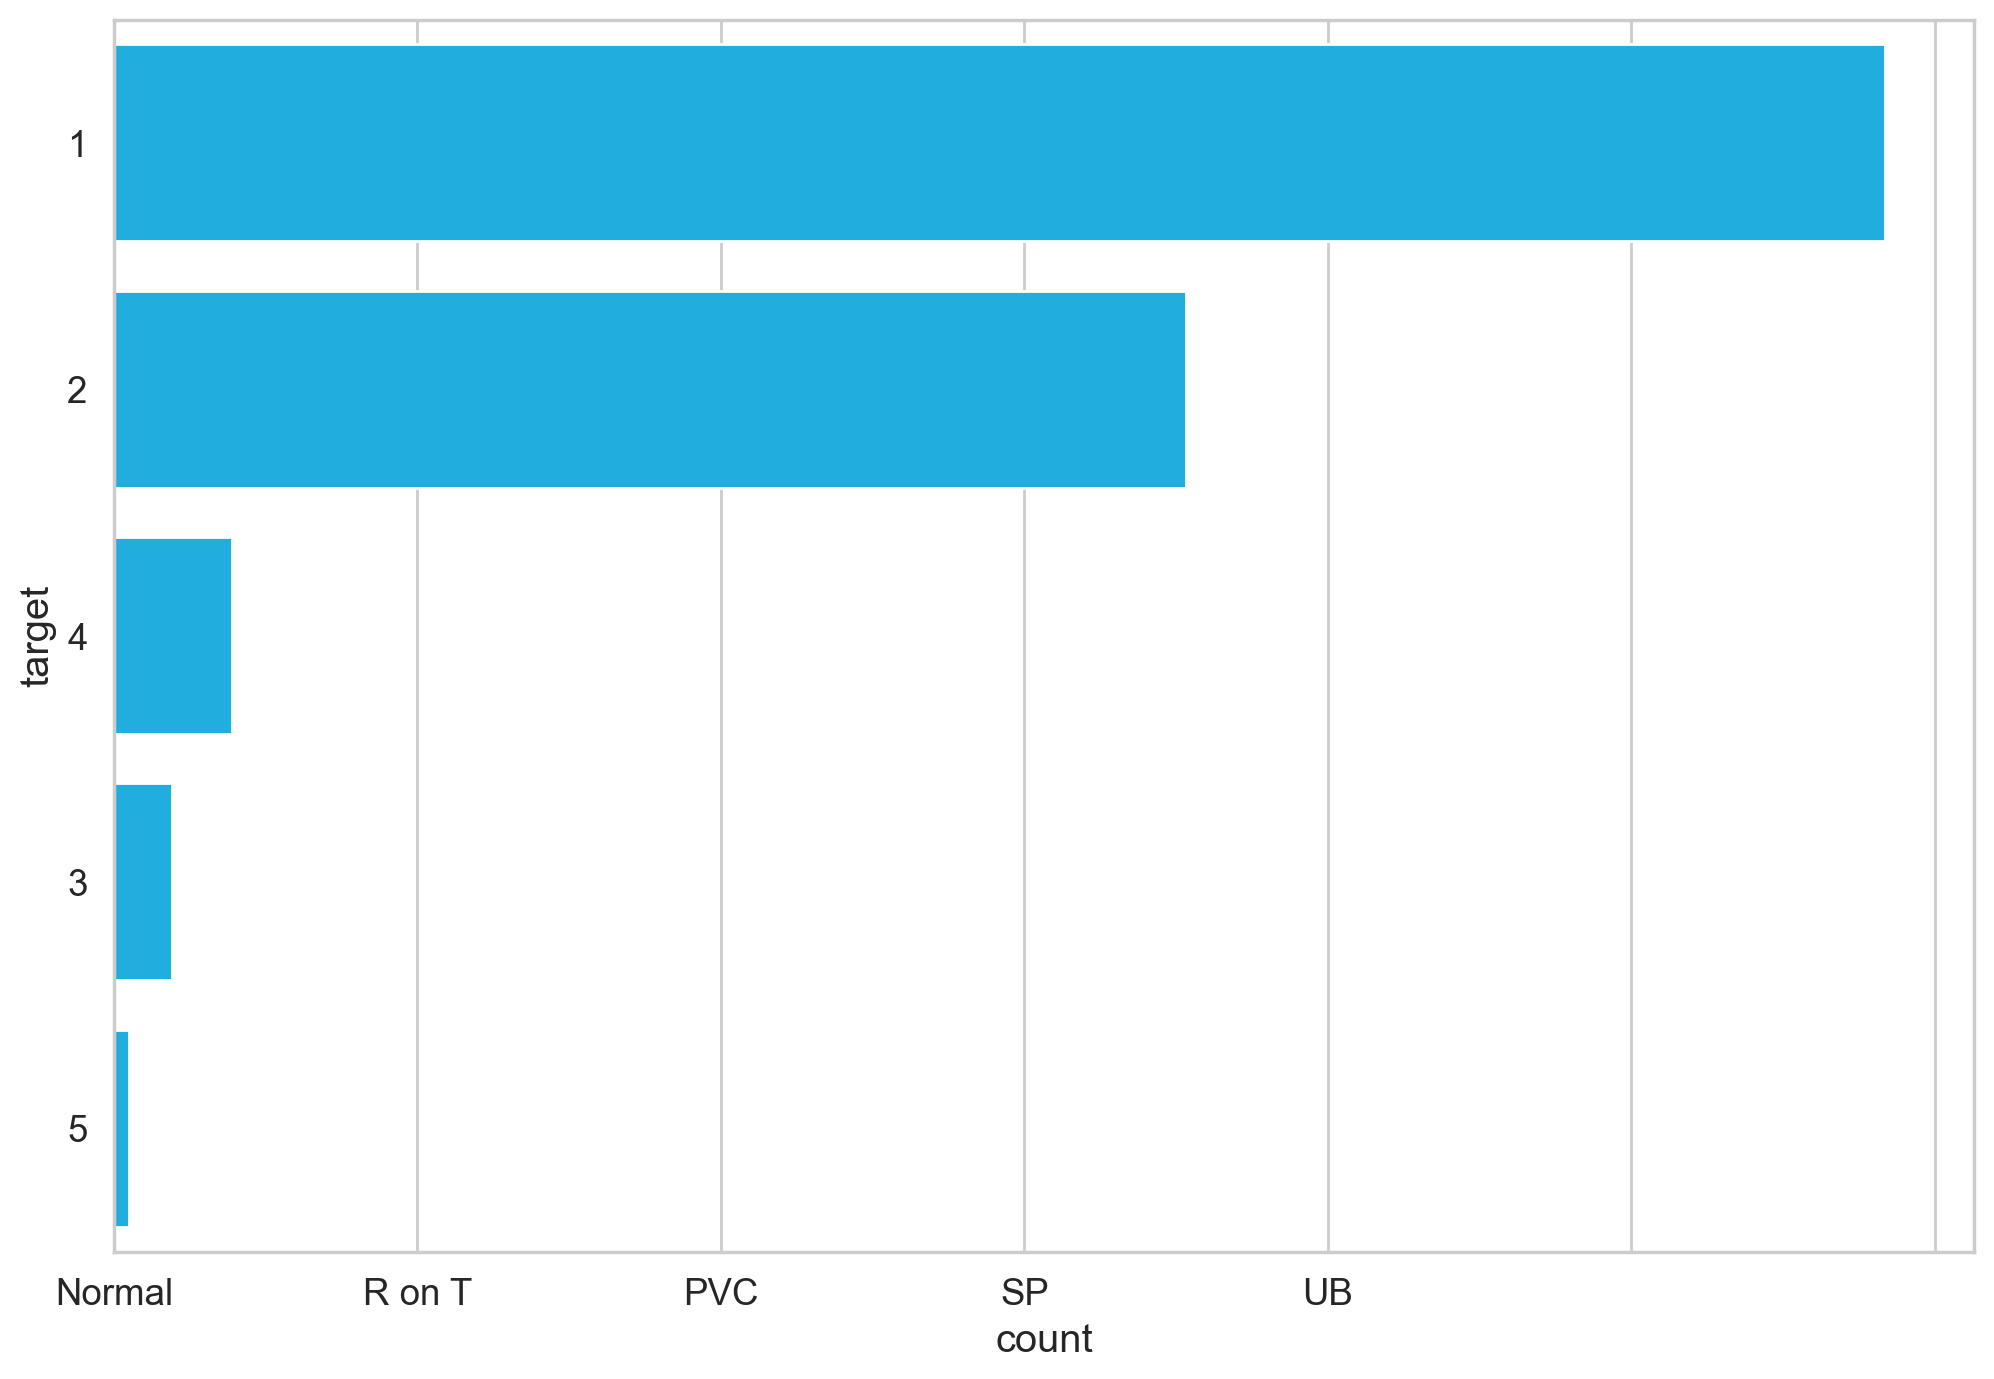

In [177]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [178]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [179]:
df[df.target == str(CLASS_NORMAL)] \
 .drop(labels='target', axis=1)\
 .mean(axis=0).shape

(140,)

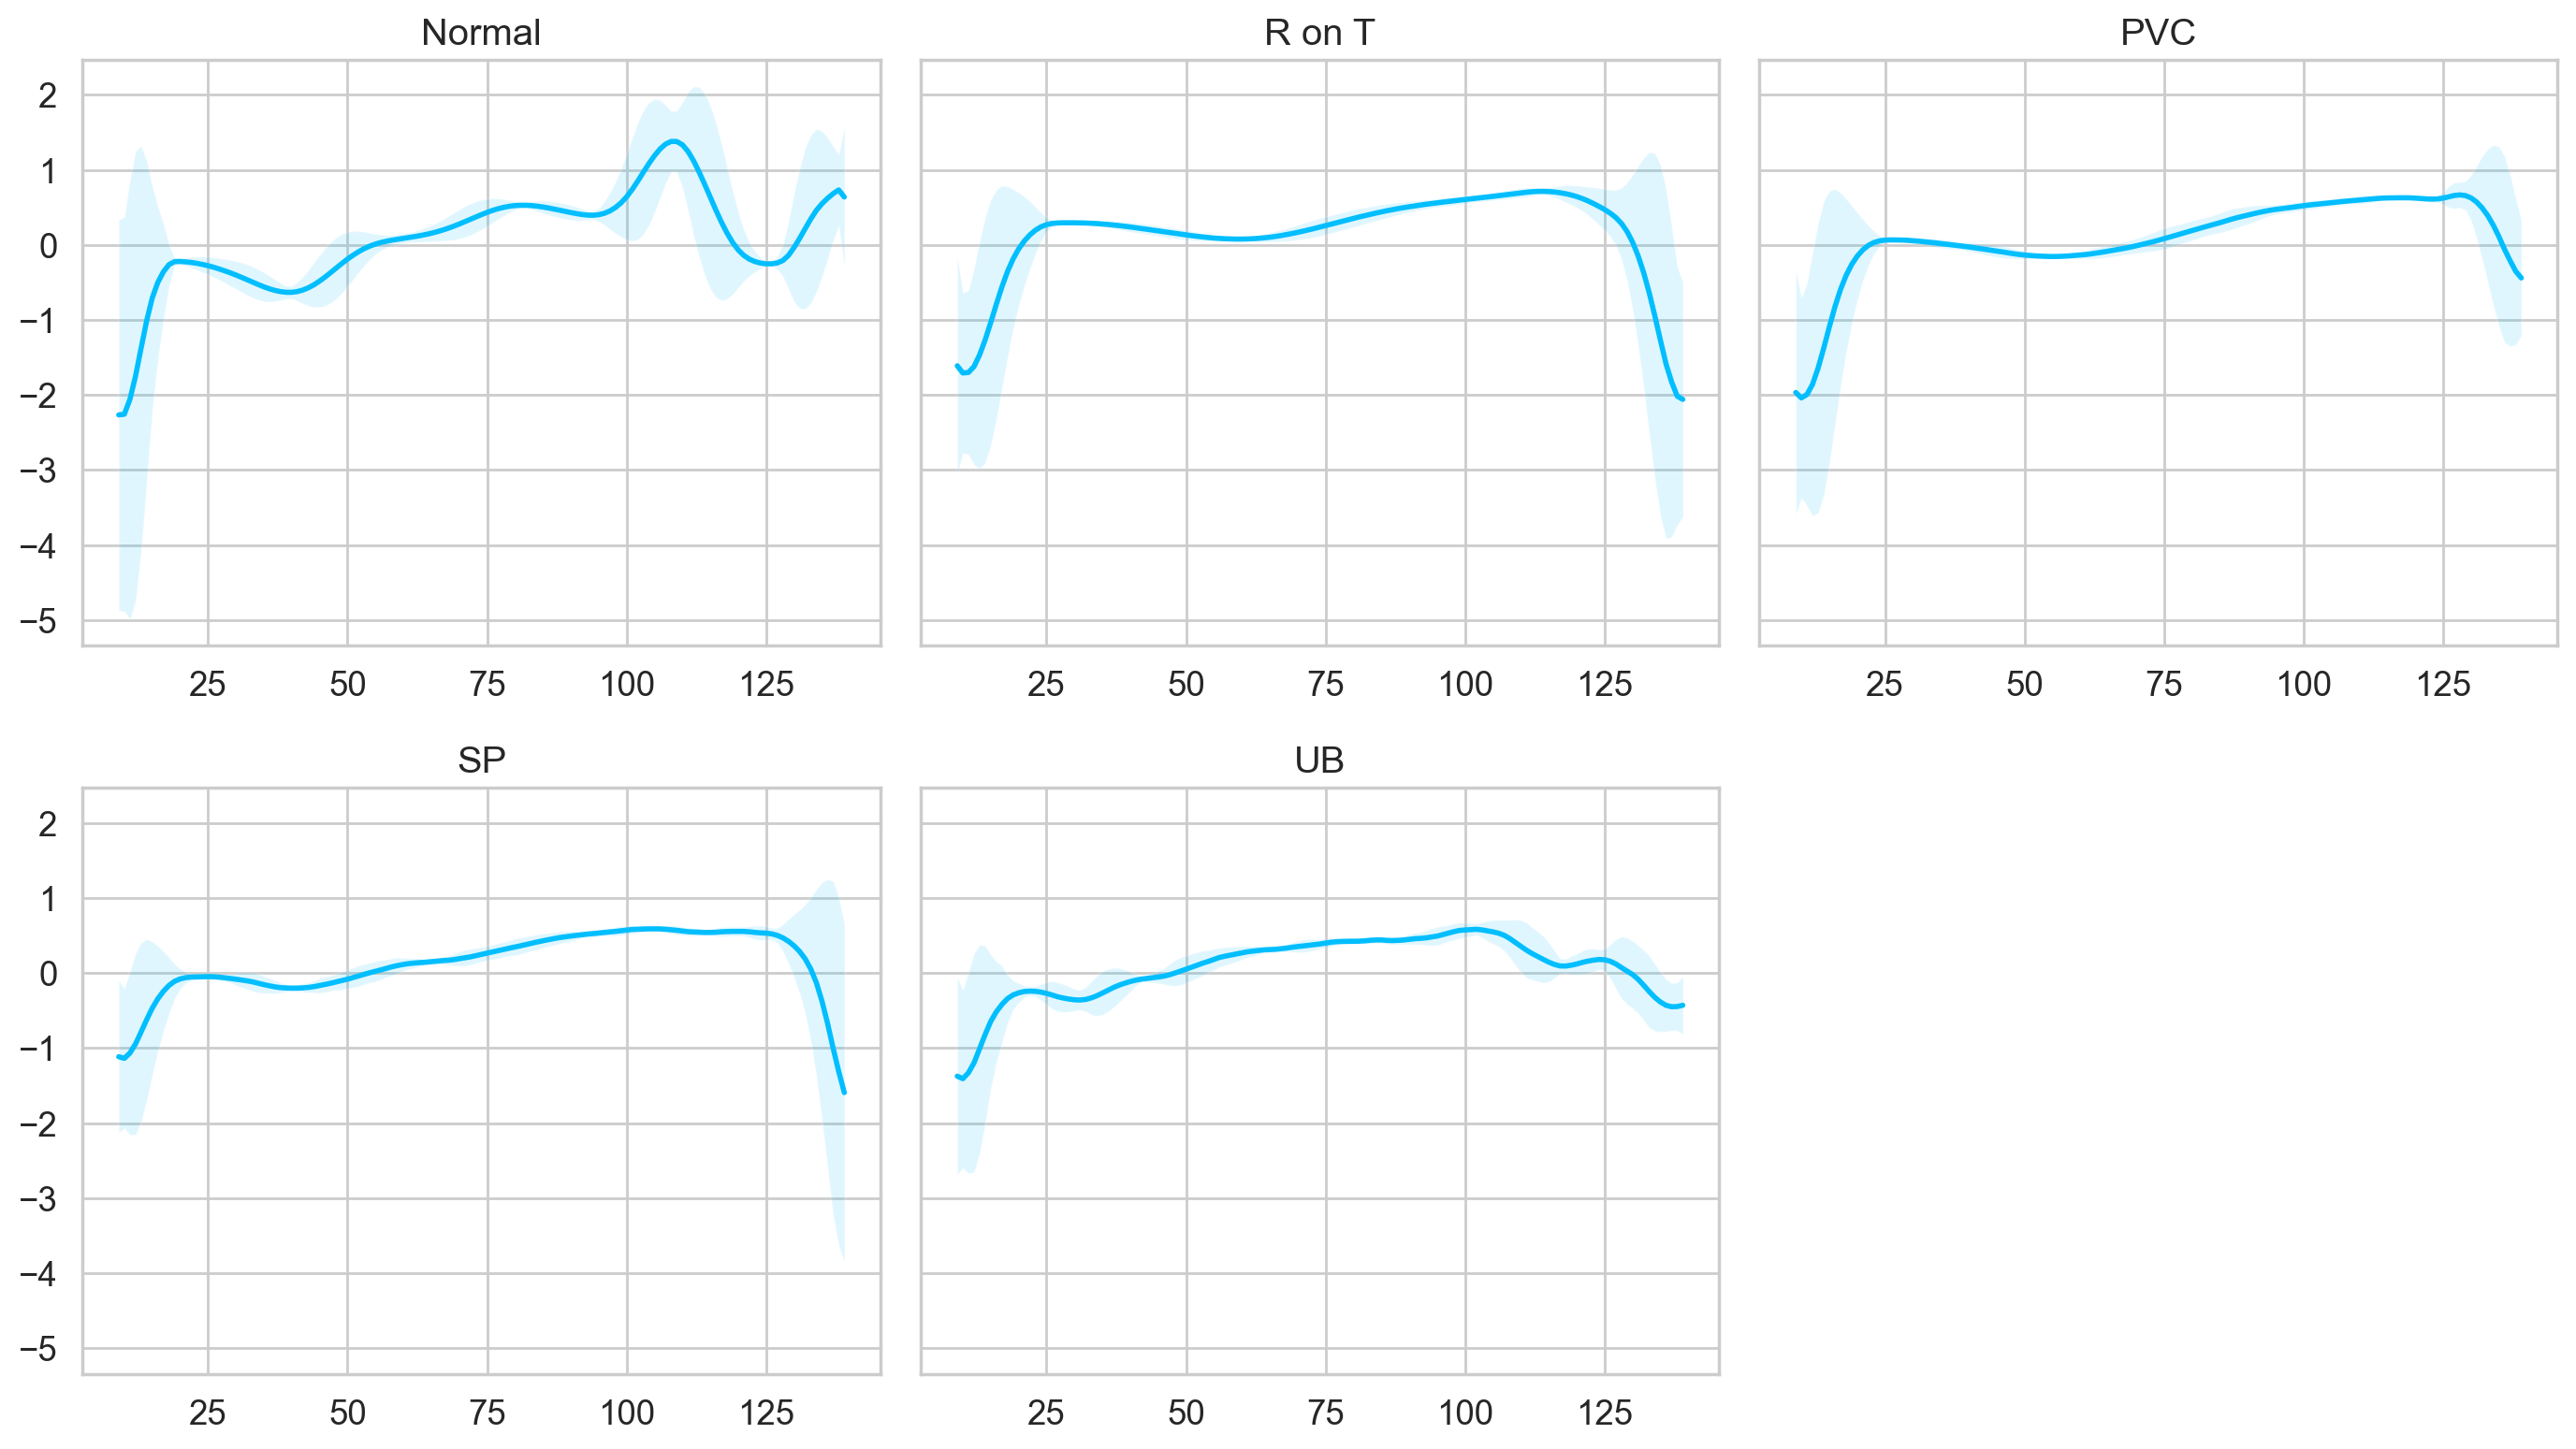

In [180]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes.
# LSTM Autoencoder

An Autoencoder is a type of model that takes some input data, processes it through the model, and then tries to recreate the original input. The goal is for the recreated output to be as close to the original input as possible. The key idea is to use a smaller number of parameters in the model, so it learns to represent the data in a more compact or simplified form. Autoencoders aim to learn the most important parts of the data by creating a simplified, compressed version. In this case, we'll explore how to use an Autoencoder with Time Series data. Specifically, we'll use LSTM layers (which are good at handling sequences) to understand patterns over time.

To identify whether a sequence is normal or an anomaly, we'll set a threshold. If a heartbeat's reconstruction error is above this threshold, we'll consider it abnormal.

Anomaly Detection in ECG Data
We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

# Data Preprocessing

In [181]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)


In [182]:
normal_df.shape

(2919, 140)

In [183]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)

In [184]:
anomaly_df.shape

(2081, 140)

In [186]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)
  

In [187]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [188]:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))
     

In [189]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)
     

In [190]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [191]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [197]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=15
)
   

Epoch 1: train loss 25.692357712530022 val loss 26.901860666763252
Epoch 2: train loss 25.07591605119194 val loss 27.852278084478282
Epoch 3: train loss 24.591076725195222 val loss 27.6609590354633
Epoch 4: train loss 24.45174431637476 val loss 27.293908216847495
Epoch 5: train loss 23.87953085132493 val loss 23.852581815101182
Epoch 6: train loss 23.28609532898638 val loss 22.544614479403446
Epoch 7: train loss 23.548998985305904 val loss 24.681459742601415
Epoch 8: train loss 22.67888316892895 val loss 23.264275036574222
Epoch 9: train loss 22.26512169828342 val loss 21.79706037410697
Epoch 10: train loss 21.827191588475984 val loss 21.130559429780615
Epoch 11: train loss 21.333693959068167 val loss 20.50537171217362
Epoch 12: train loss 20.82197669627733 val loss 19.94179357847663
Epoch 13: train loss 20.268045932426897 val loss 19.805184465219543
Epoch 14: train loss 19.654042871668185 val loss 18.938974038732745
Epoch 15: train loss 19.222968317144872 val loss 18.246100702383412


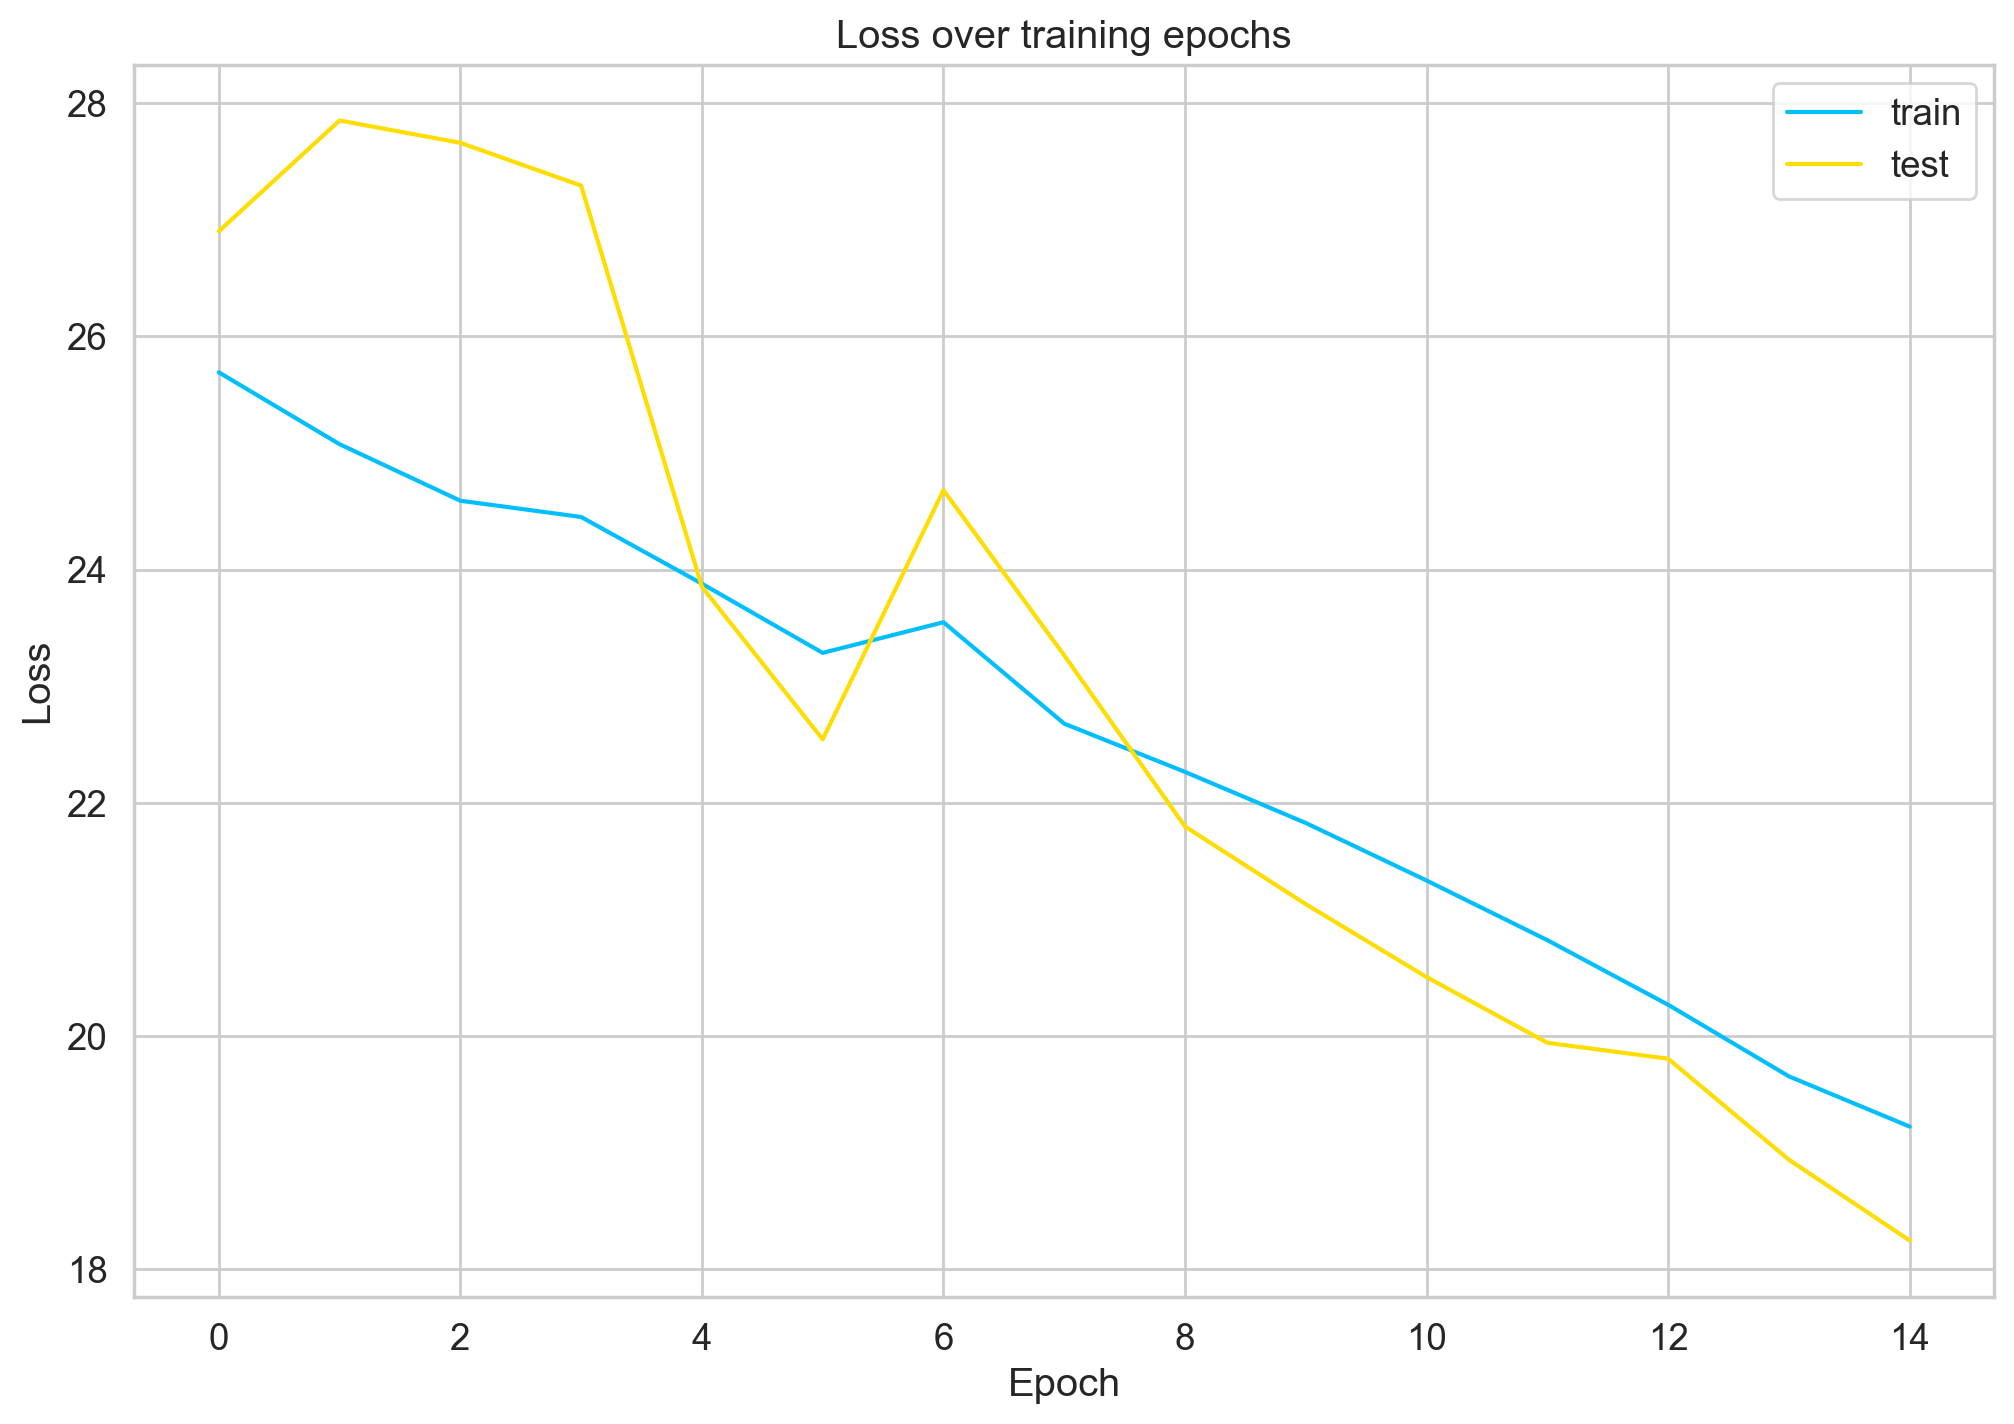

In [198]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [199]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [200]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses
     

/var/folders/2r/p_w4swwd3cv52b3h9nn1njtm0000gn/T/ipykernel_1041/99475105.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


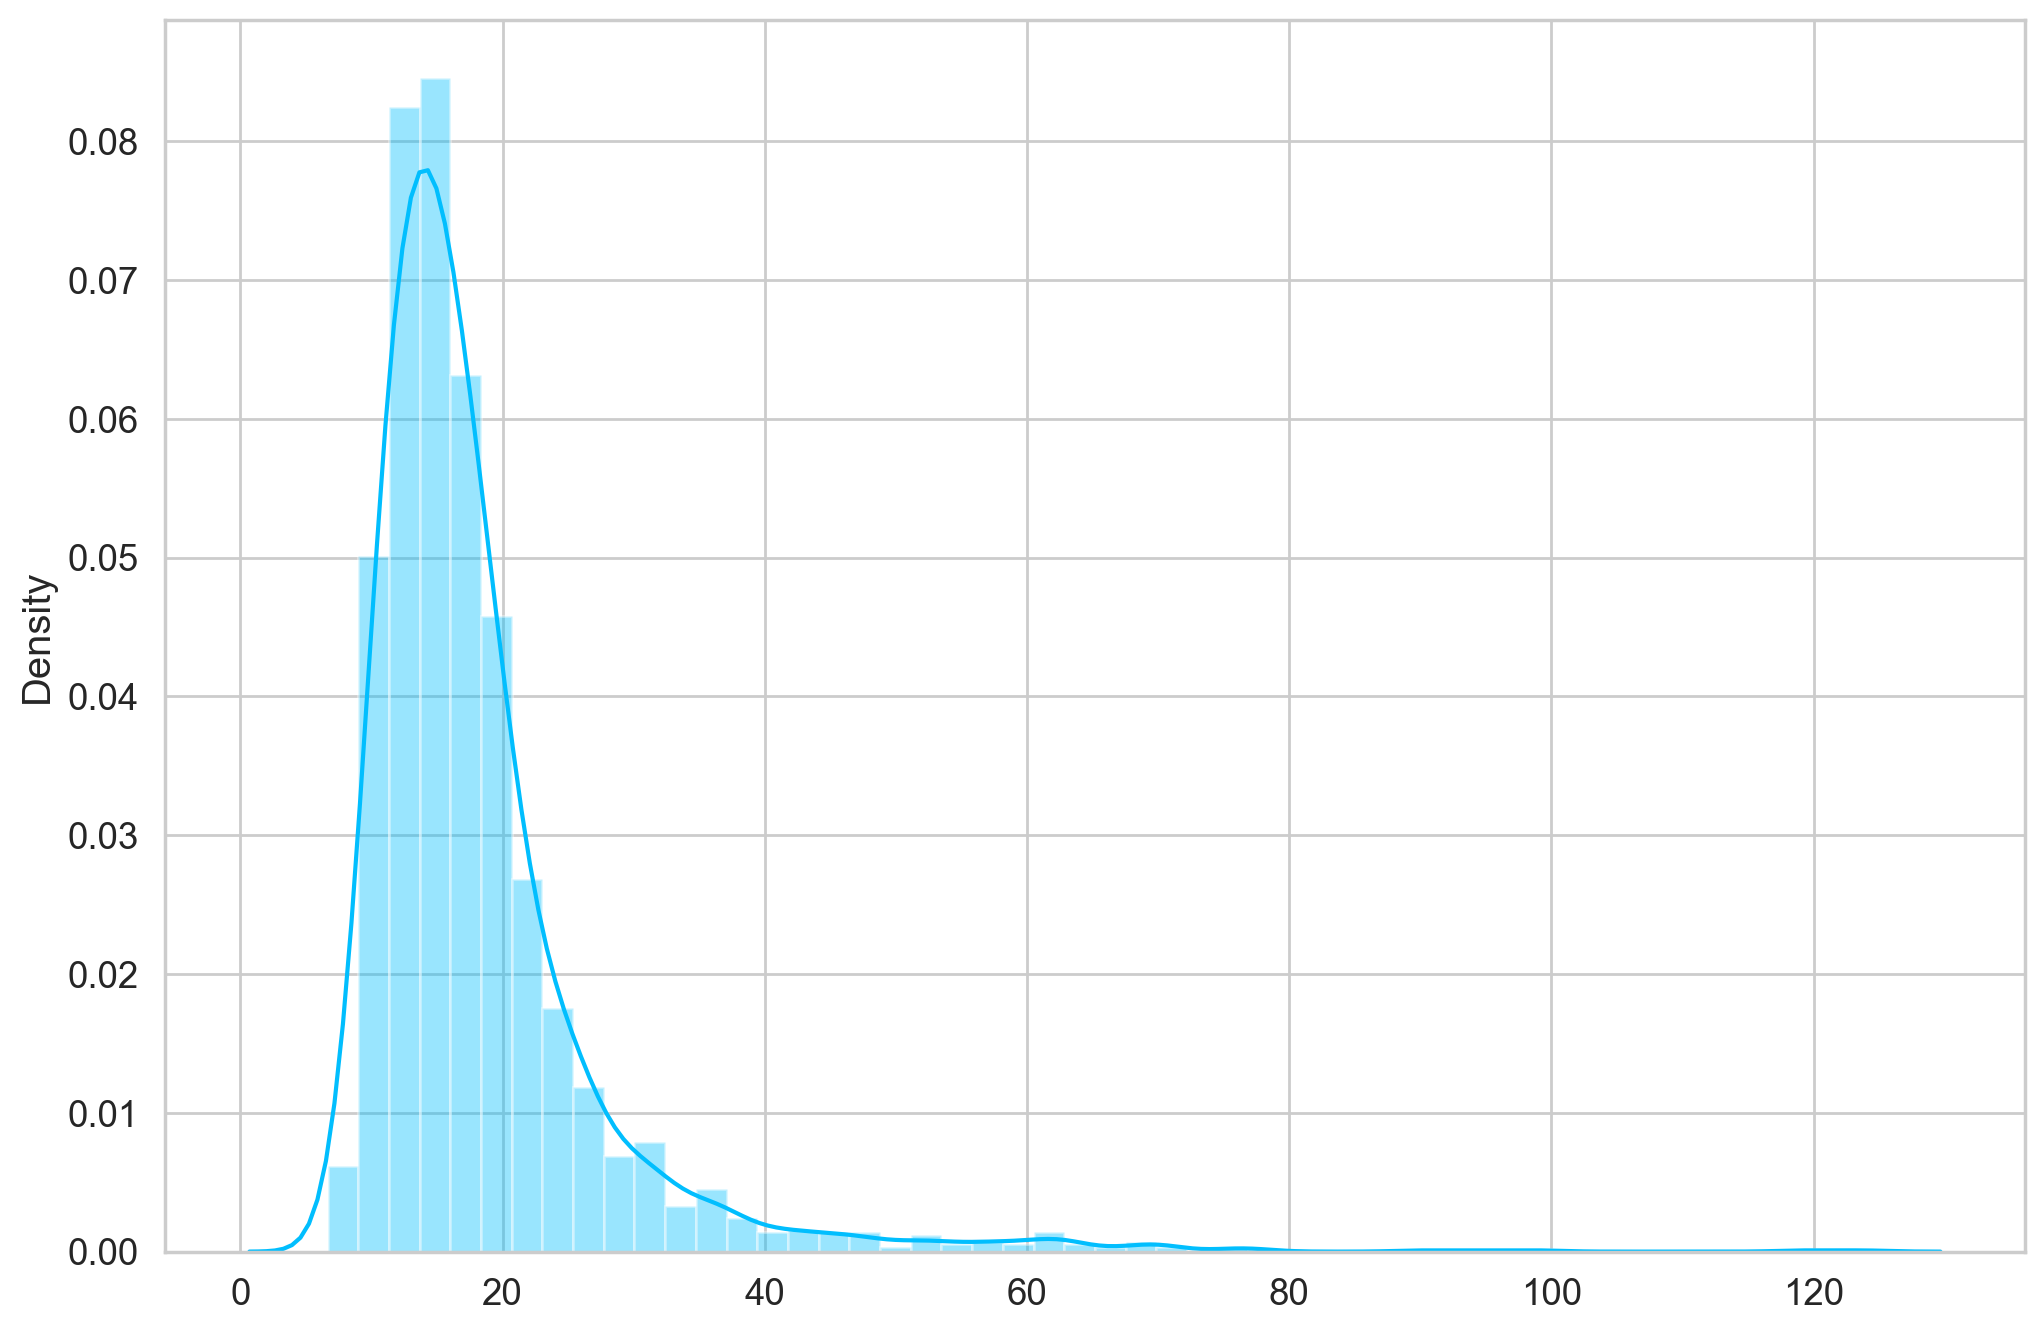

In [204]:

_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [205]:
THRESHOLD = 26

/var/folders/2r/p_w4swwd3cv52b3h9nn1njtm0000gn/T/ipykernel_1041/3242963548.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


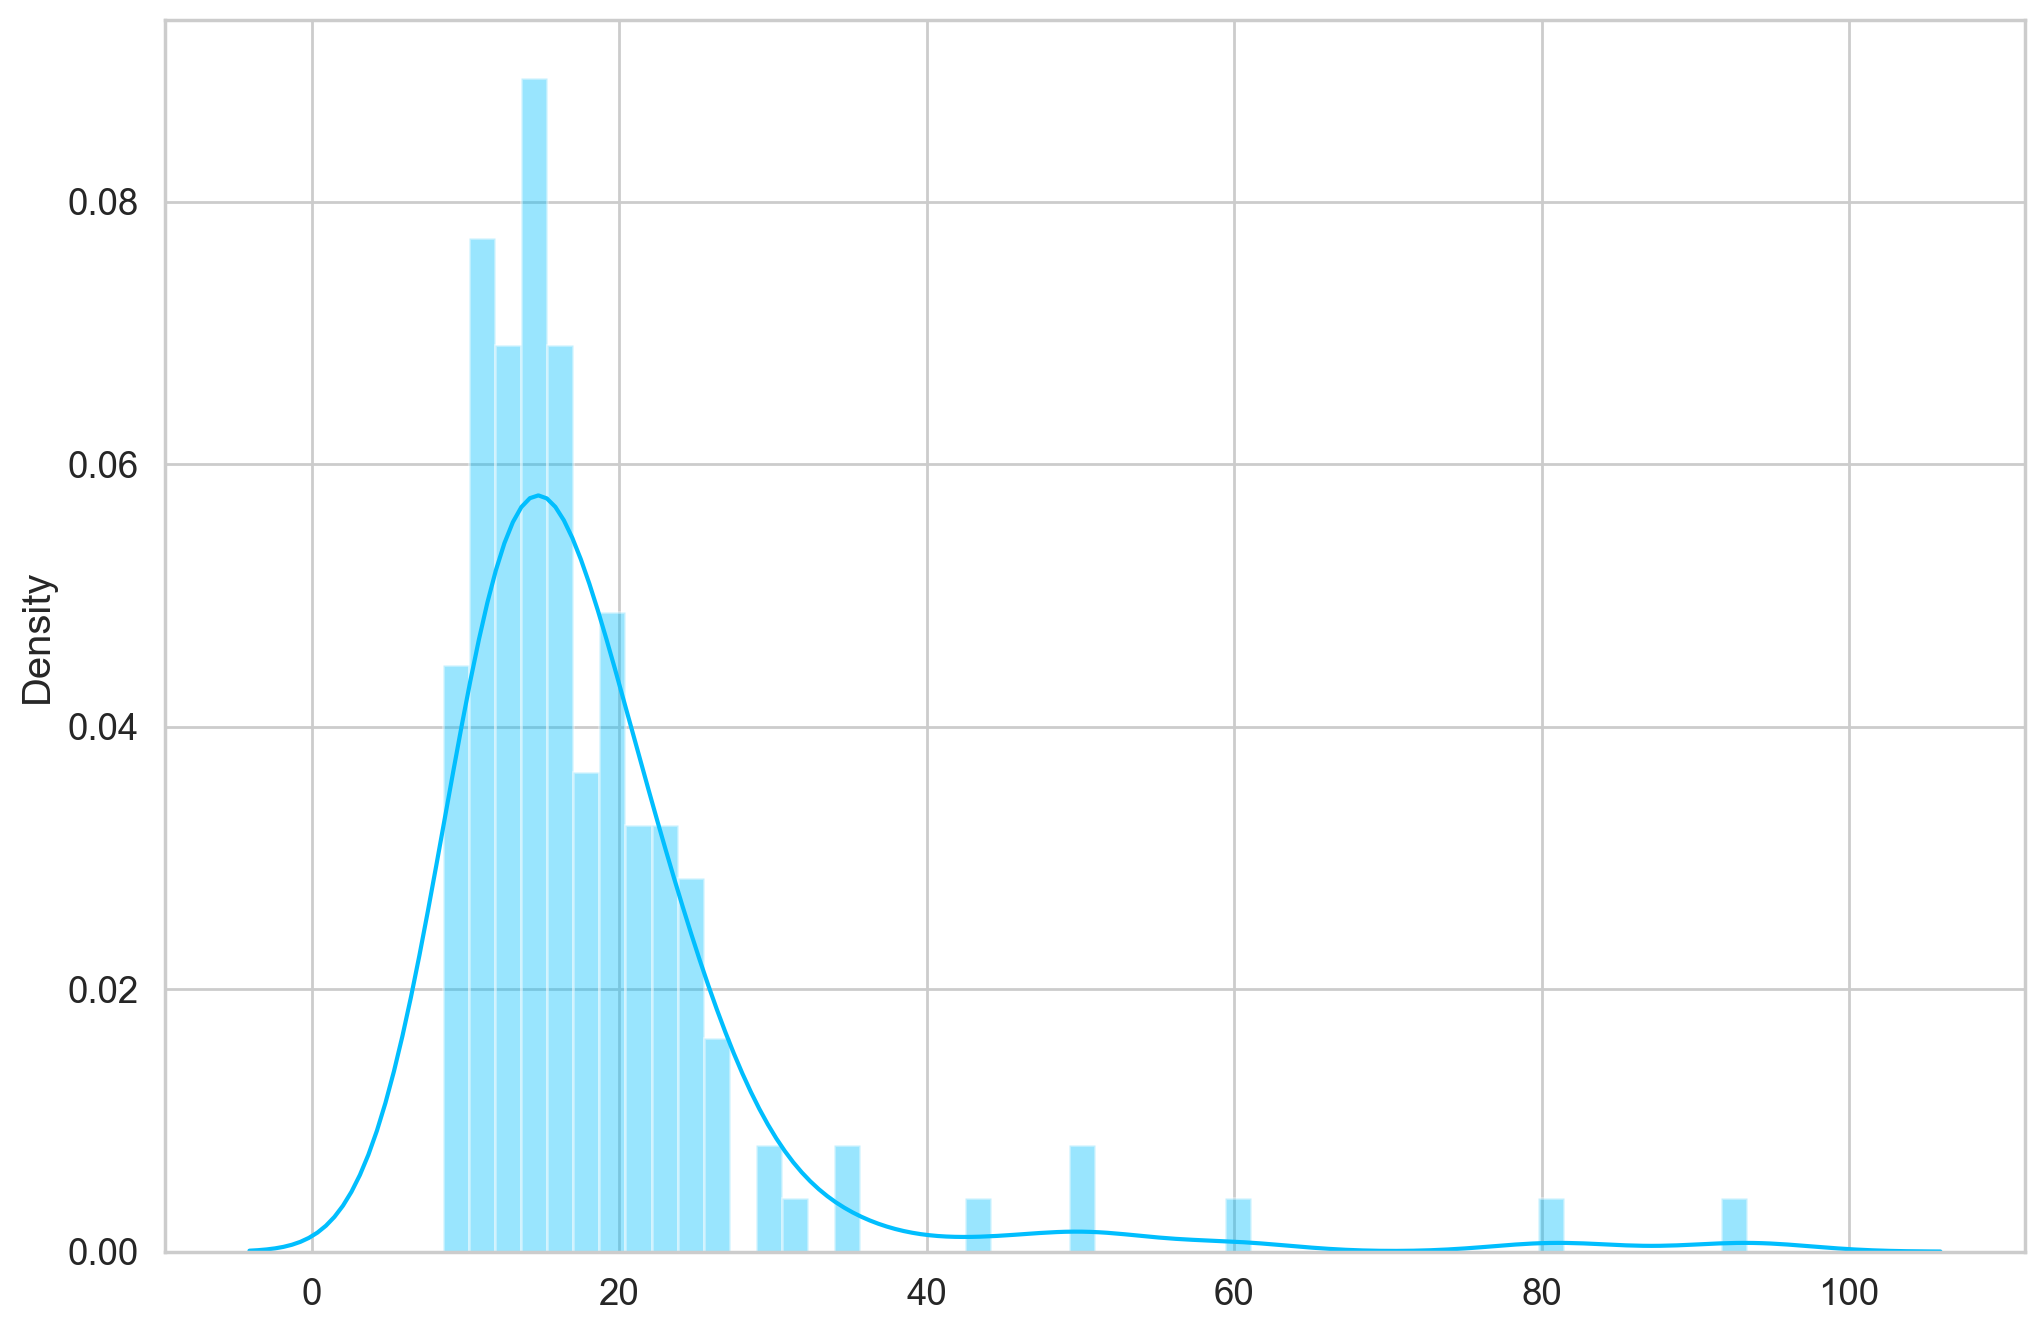

In [206]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [207]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 130/145


In [208]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/var/folders/2r/p_w4swwd3cv52b3h9nn1njtm0000gn/T/ipykernel_1041/1155070466.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


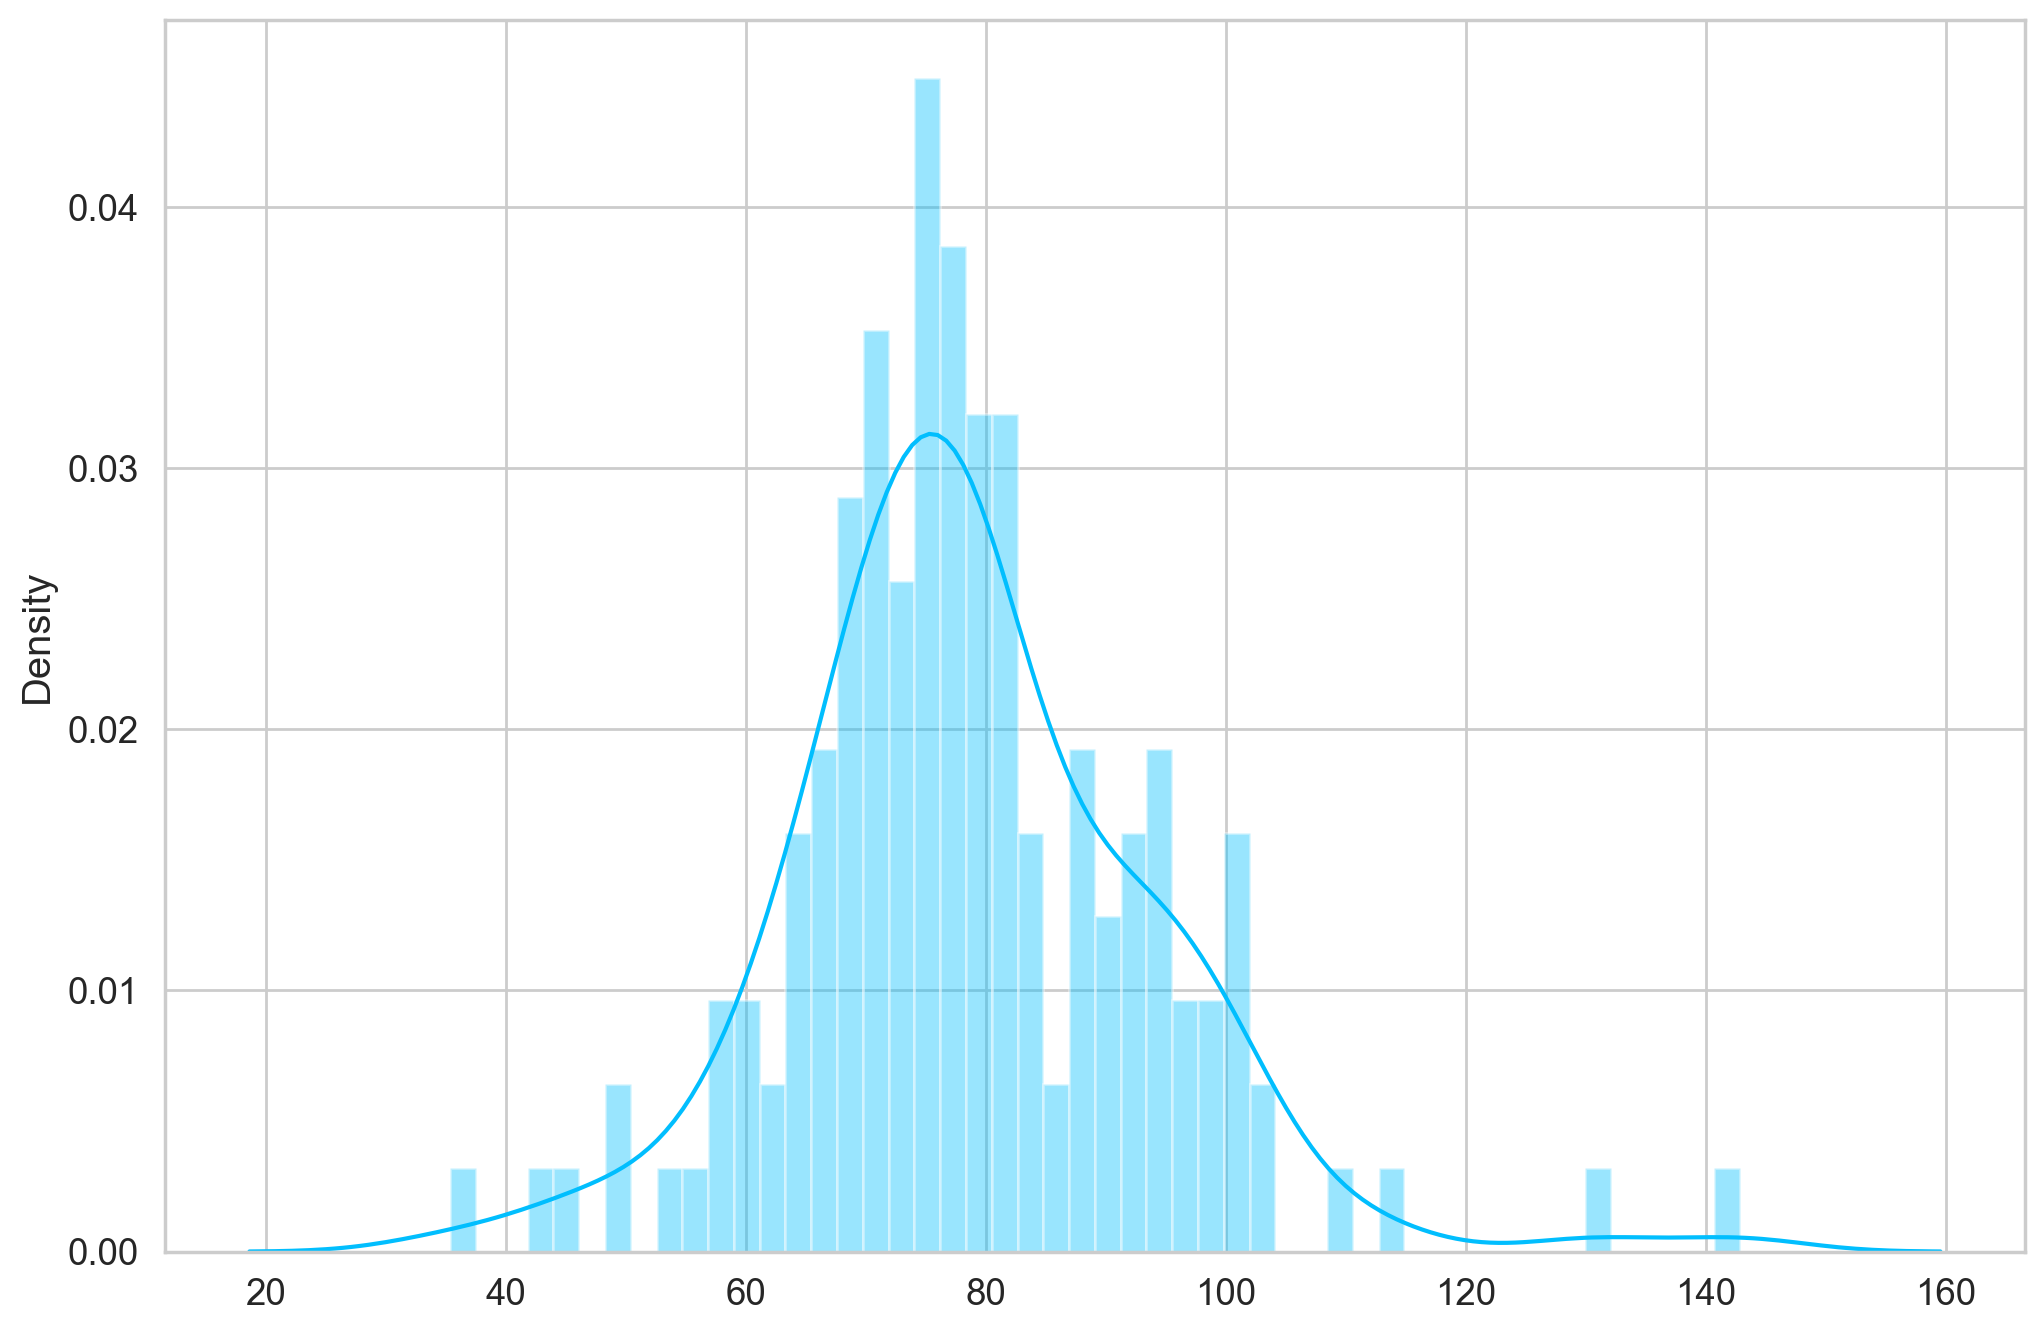

In [209]:

predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [210]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 145/145


In [211]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

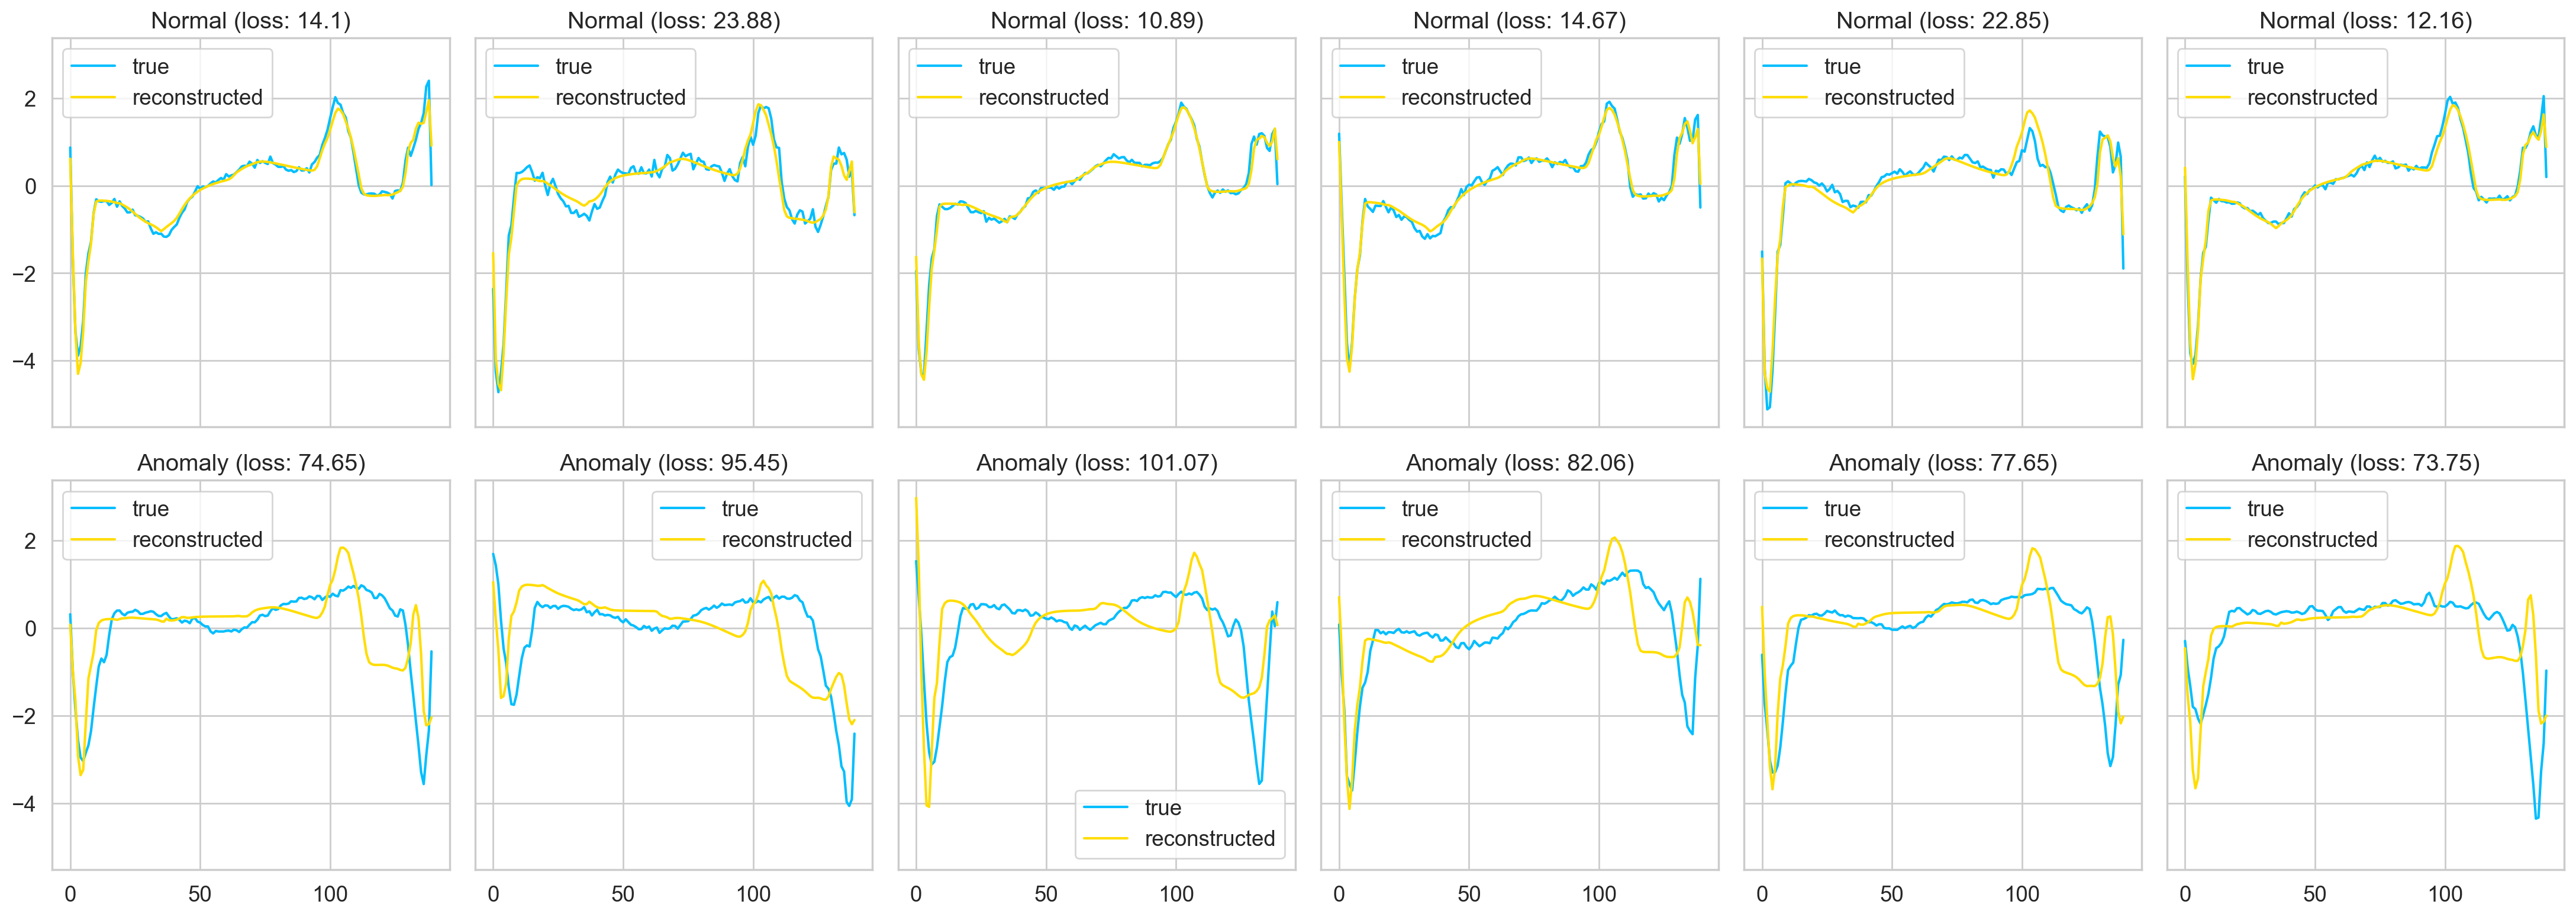

In [212]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();